In [1]:

#1.2 clarify- log reg still can't be solved?
#2.4 clarify- why is lin reg poor even if not much diff than log reg?

#3.5 may need to update if run bootstrapping again

#4.4 interpret the results and put data points on decision boundary plots?




# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Logistic Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- **This is an individual homework. No group collaboration.**
- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw4.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [20 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.


**1.3** Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.

Plot two histograms ofyour best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.

Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.


**1.4** Using your top gene from the previous part (call it  `best_predictor`), create a classification model by manually eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.

<hr> <hr>

<hr>
### Solutions

**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [3]:
# Split data into 80-20 train-test split
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)


X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [4]:
# Print shape of data before splitting
print('Shape before splitting:', df.shape)
# Print shape of data after splitting
print('\nTraining predictor data after splitting:', X_train.shape, '\nTesting predictor data after splitting:', X_test.shape, '\nResponse training data after splitting:', y_train.shape, '\nResponse testing data after splitting:', y_test.shape)
print('\nProportion of ALL cases (0) vs. AML cases (1) across all data:\n',df.Cancer_type.value_counts(normalize=True))


Shape before splitting: (752, 7130)

Training predictor data after splitting: (601, 7129) 
Testing predictor data after splitting: (151, 7129) 
Response training data after splitting: (601,) 
Response testing data after splitting: (151,)

Proportion of ALL cases (0) vs. AML cases (1) across all data:
 0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.**


In [5]:
# Check predictor gene values before normalization
print('\nInspect gene names:\n', X_train.columns) # Confirm that the columns are gene names
print('\nInspect first few genes:\n', X_train.head()) # Overall there is much variability in the measurements of each gene even just in the first 5 measurements
print('\nInspect predictor summary statistics:\n', X_train.describe()) # The mean measurement value for each gene varies considerably, as does the minimum and maximum values 
print('\nOverall mean:\n', X_train.stack().mean())
print('\nOverall standard deviation:\n', X_train.stack().std()) # Standard deviation of measurements across all genes is much higher than the mean overall



Inspect gene names:
 Index(['AFFX-BioB-5_at', 'AFFX-BioB-M_at', 'AFFX-BioB-3_at', 'AFFX-BioC-5_at',
       'AFFX-BioC-3_at', 'AFFX-BioDn-5_at', 'AFFX-BioDn-3_at',
       'AFFX-CreX-5_at', 'AFFX-CreX-3_at', 'AFFX-BioB-5_st',
       ...
       'U48730_at', 'U58516_at', 'U73738_at', 'X06956_at', 'X16699_at',
       'X83863_at', 'Z17240_at', 'L49218_f_at', 'M71243_f_at', 'Z78285_f_at'],
      dtype='object', length=7129)

Inspect first few genes:
      AFFX-BioB-5_at  AFFX-BioB-M_at  AFFX-BioB-3_at  AFFX-BioC-5_at  \
486      -83.669345     -129.202197       91.188553     -132.634919   
604      -65.718571     -302.842019     -297.819728     -177.485917   
341     -264.191248     -162.255274      127.997172      173.771779   
117      -92.558574     -109.788332      379.542547      391.641129   
516     -143.099813      140.202023     -147.163850      222.339115   

     AFFX-BioC-3_at  AFFX-BioDn-5_at  AFFX-BioDn-3_at  AFFX-CreX-5_at  \
486     -416.659258      -566.248620      -549.2552

In [6]:
# Normalize values of each predictor
#x_reshaped = np.array(X_train).reshape(-1,1) # reshape in order to pass data into MinMaxScaler for normalization
#X_train_scaled = MinMaxScaler().fit_transform(x_reshaped)
#X_train = pd.DataFrame(X_train_scaled.reshape(len(X_train),len(X_train.columns)),columns=X_train.columns) # convert X_train from an numpy.ndarray back into a dataframe 
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)

In [7]:
X_train_scaled.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
486,0.574689,0.652904,0.528552,0.202384,0.504132,0.309107,0.439480,0.524446,0.723161,0.411162,...,0.516278,0.391074,0.752595,0.484137,0.683508,0.389115,0.413169,0.562775,0.538180,0.524258
604,0.587407,0.535608,0.249427,0.171417,0.752874,0.513878,0.655342,0.464181,0.324602,0.559483,...,0.635019,0.317177,0.700050,0.336964,0.454571,0.406687,0.339430,0.452814,0.388218,0.380795
341,0.446787,0.630576,0.554963,0.413946,0.662329,0.665892,0.145850,0.648430,0.478307,0.551411,...,0.439609,0.233910,0.235984,0.343672,0.733797,0.369846,0.323172,0.500478,0.457391,0.556345
117,0.568391,0.666018,0.735454,0.564376,0.662796,0.302675,0.513584,0.359108,0.706408,0.272227,...,0.574234,0.449615,0.426995,0.390941,0.650875,0.615891,0.251946,0.695112,0.436069,0.458655
516,0.532581,0.834889,0.357527,0.447480,0.631015,0.198841,0.678084,0.515280,0.487490,0.440010,...,0.539831,0.543511,0.528163,0.442338,0.578272,0.404435,0.531047,0.372191,0.751796,0.469227


In [8]:
# Check predictor gene values after normalization
print('\nInspect gene names:\n', X_train_scaled.columns) # Confirm that the columns are gene names
print('\nInspect first few genes:\n', X_train_scaled.head()) # Overall there is less variability in the measurements of each gene even just in the first 5 measurements
print('\nInspect predictor summary statistics:\n', X_train_scaled.describe()) # The mean measurement value for each gene does not vary considerably; max and min values are 1 and 0, respectively
print('\nOverall mean:\n', X_train_scaled.stack().mean())
print('\nOverall standard deviation:\n', X_train_scaled.stack().std()) # Standard deviation of measurements across all genes is not much higher than the mean overall



Inspect gene names:
 Index(['AFFX-BioB-5_at', 'AFFX-BioB-M_at', 'AFFX-BioB-3_at', 'AFFX-BioC-5_at',
       'AFFX-BioC-3_at', 'AFFX-BioDn-5_at', 'AFFX-BioDn-3_at',
       'AFFX-CreX-5_at', 'AFFX-CreX-3_at', 'AFFX-BioB-5_st',
       ...
       'U48730_at', 'U58516_at', 'U73738_at', 'X06956_at', 'X16699_at',
       'X83863_at', 'Z17240_at', 'L49218_f_at', 'M71243_f_at', 'Z78285_f_at'],
      dtype='object', length=7129)

Inspect first few genes:
      AFFX-BioB-5_at  AFFX-BioB-M_at  AFFX-BioB-3_at  AFFX-BioC-5_at  \
486        0.574689        0.652904        0.528552        0.202384   
604        0.587407        0.535608        0.249427        0.171417   
341        0.446787        0.630576        0.554963        0.413946   
117        0.568391        0.666018        0.735454        0.564376   
516        0.532581        0.834889        0.357527        0.447480   

     AFFX-BioC-3_at  AFFX-BioDn-5_at  AFFX-BioDn-3_at  AFFX-CreX-5_at  \
486        0.504132         0.309107         0.4394

In [9]:
# Also normalize predictors in the testing data
# should it be X_test in the fit_transform or should it be X_train here? Want to normalize according to the training data

#X_test_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df.loc[:, df.columns != 'Cancer_type']), columns=X_test.columns)

X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns=X_test.columns)

In [10]:
# Check that normalizing was successful (max should be 1 and min 0 for each predictor)
X_test_scaled.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,...,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,0.558739,0.628584,0.483741,0.433760,0.611364,0.372105,0.575820,0.523991,0.631786,0.517030,...,0.556287,0.508939,0.464691,0.392301,0.604984,0.531941,0.394276,0.515471,0.515281,0.454457
std,0.122118,0.138197,0.147509,0.134576,0.141210,0.138466,0.140544,0.152170,0.114369,0.146962,...,0.121811,0.150016,0.152998,0.105910,0.150592,0.129336,0.136484,0.145916,0.150673,0.135950
min,0.222337,0.052362,0.124898,0.105928,0.071105,0.050836,0.156020,0.039091,0.320783,0.206945,...,0.201957,0.070354,0.172558,0.181925,0.141525,0.149185,0.120792,0.140083,0.166168,0.054844
25%,0.499868,0.548335,0.388016,0.345367,0.521641,0.273796,0.489531,0.422420,0.560308,0.435264,...,0.484829,0.403865,0.355955,0.334083,0.513409,0.455015,0.306536,0.418288,0.426565,0.368567
50%,0.560659,0.642539,0.460060,0.434223,0.627556,0.361920,0.573224,0.539889,0.625199,0.505667,...,0.558503,0.486221,0.469452,0.383539,0.599456,0.523538,0.375118,0.521046,0.502907,0.449302
75%,0.637131,0.711483,0.581579,0.522510,0.689237,0.469692,0.647892,0.634494,0.713072,0.592525,...,0.628399,0.610960,0.562807,0.426880,0.707865,0.613968,0.486736,0.620235,0.601599,0.521765
max,0.866908,0.890931,0.962346,0.809448,1.083614,0.707036,0.935497,0.920072,0.948824,1.135258,...,0.904706,0.956029,0.930731,0.837301,0.964234,0.856707,0.771090,0.860715,1.030505,0.867071


In [11]:
X_test_scaled.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
515,0.611279,0.508174,0.715863,0.151505,0.784430,0.413482,0.836748,0.829443,0.549521,0.263033,...,0.727341,0.570841,0.569006,0.345588,0.521598,0.570938,0.493602,0.610933,0.465889,0.515340
192,0.257323,0.691342,0.404597,0.499137,0.718397,0.380575,0.607302,0.473850,0.665825,0.486875,...,0.569877,0.650974,0.682418,0.273021,0.794193,0.637596,0.624306,0.724003,0.432130,0.316509
457,0.224116,0.589906,0.643881,0.332222,0.445394,0.437889,0.620473,0.649054,0.753119,0.580461,...,0.814274,0.782606,0.790134,0.226709,0.875852,0.712236,0.530283,0.678924,0.590148,0.449474
577,0.546180,0.672524,0.367985,0.439012,0.737901,0.345048,0.528315,0.736581,0.751400,0.382117,...,0.514091,0.395313,0.417766,0.400581,0.634293,0.360998,0.205097,0.390063,0.387687,0.352107
141,0.472612,0.740084,0.498924,0.490403,0.598089,0.490106,0.363334,0.502310,0.512419,0.534564,...,0.448586,0.380909,0.752446,0.326369,0.592830,0.602877,0.265719,0.393911,0.410379,0.439480


**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.**

A classification model fit to a dataset with more predictors than observations can have overfitting. This is because the estimates for the effect of each predictor on the response variable will be very unstable since the classification model may be fitting noise rather than  the true signal and since there may be much multicolinearity (the latter is especially likely in the case where the predictors are genes, as in this problem, since many genes are regulated  together and therefore expressed in correlated patters). In classifiers that are built from linear regression models (such as a Bayes classifier, where observations having predicted probabilities <0.5 are classified into one group and observations with predicted probabilities  >0.5 are classified into the other), having more predictors than observations makes the linear regression not have a deterministic solution (since more unknowns than equations- resulting in there being multiple solutions that fit the data equally well) and there will also be high overfitting but even in logistic regression (which does not have a closed form solution, i.e., is not deterministic) there will be a great deal of overfitting when there are more predictors than observations. 

**1.3** **Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.**

**Plot two histograms of your best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.**

**Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.**

In [12]:
# Check whether there is a significant difference in measurement value for each gene individually between ALL and AML cases using training data and visualize the dicriminatory effect of the most differential gene in the testing set as well

ALL_y_train = y_train[y_train == 0].index
AML_y_train = y_train[y_train == 1].index
t_stat_list = []

for column in X_train_scaled.columns:
        ALL_group = X_train_scaled[column][ALL_y_train]
        AML_group = X_train_scaled[column][AML_y_train]
        numerator = np.abs(ALL_group.mean() - AML_group.mean())
        ALL_sd = ALL_group.std()
        AML_sd = AML_group.std()
        denom = np.sqrt((ALL_sd**2)/len(ALL_group) + (AML_sd**2)/len(AML_group))
        t_stat = numerator/denom
        t_stat_list.append(t_stat)       

In [13]:
# Show t statistics assessing difference in measurement values between ALL and AML cases for every gene as a dataframe
d = {'gene': X_train_scaled.columns, 't_stat': t_stat_list}
gene_t_stats = pd.DataFrame(d)

In [14]:
gene_t_stats['t_stat'].max()

12.537397241580127

In [15]:
# Find top 10 most differential genes

# Find index values for top 10 t statistics (already these are all positive because the absolute value was taken when calculating t statistic)
# np.argsort sorts from smallest to largest
top_10_index = np.argsort(t_stat_list)[-10:]
print('Top 10 most differential genes:\n', list(X_train_scaled.iloc[:,top_10_index].columns))

top_1_index = np.argsort(t_stat_list)[-1:]
print('Best predictor gene:\n', list(X_train_scaled.iloc[:,top_1_index].columns))

Top 10 most differential genes:
 ['X76648_at', 'Z11793_at', 'Y08612_at', 'U29175_at', 'X17042_at', 'U50136_rna1_at', 'X61587_at', 'M84526_at', 'X95735_at', 'M31523_at']
Best predictor gene:
 ['M31523_at']


In [16]:
# check - may delete later
gene_t_stats.loc[gene_t_stats['gene'] == 'M31523_at']

,gene,t_stat
6854,M31523_at,12.537397


In [17]:
# Confirm that gene with max t statistic 
gene_t_stats.loc[gene_t_stats['t_stat'] == gene_t_stats['t_stat'].max()]['gene']

6854    M31523_at
Name: gene, dtype: object

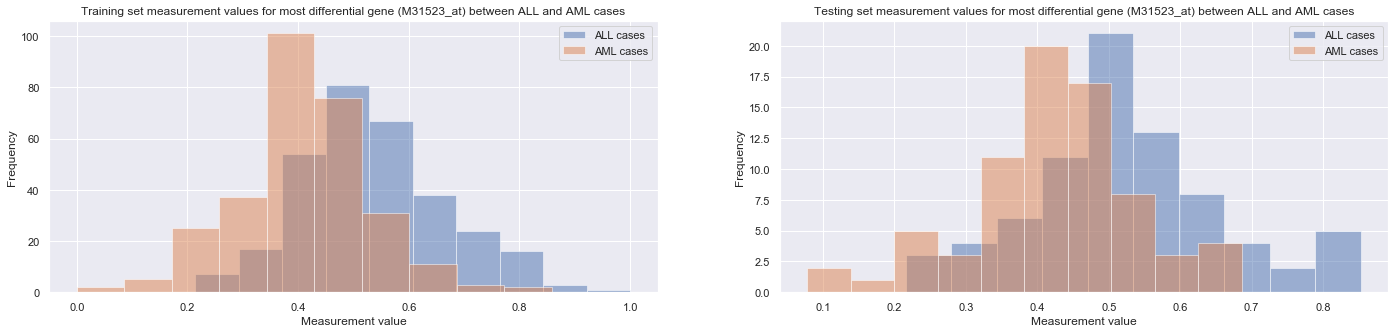

In [18]:
# Find ALL and AML cases in test data
ALL_y_test = y_test[y_test == 0].index
AML_y_test = y_test[y_test == 1].index

# Make histograms of measurement value for best predictor gene in order to observe that measurements differ between ALL and AML cases
#c = plt.subplots(nrows=1, ncols=2, figsize=(24,5))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,5))
#ax = ax.ravel()

ax[0].hist(X_train_scaled.loc[ALL_y_train,list(X_train_scaled.iloc[:,top_1_index].columns)].values, alpha = 0.5, bins=10, label="ALL cases"); # Data for ALL cases
ax[0].hist(X_train_scaled.loc[AML_y_train,list(X_train_scaled.iloc[:,top_1_index].columns)].values, alpha = 0.5, bins=10, label="AML cases"); # Data for AML cases
ax[0].set_title('Training set measurement values for most differential gene ({}) between ALL and AML cases'.format(X_train_scaled.iloc[:,top_1_index].columns[0]))
ax[0].set_xlabel('Measurement value');
ax[0].set_ylabel('Frequency');
ax[0].legend();

ax[1].hist(X_test_scaled.loc[ALL_y_test,list(X_test_scaled.iloc[:,top_1_index].columns)].values, alpha = 0.5, bins=10, label="ALL cases"); # Data for ALL cases
ax[1].hist(X_test_scaled.loc[AML_y_test,list(X_test_scaled.iloc[:,top_1_index].columns)].values, alpha = 0.5, bins=10, label="AML cases"); # Data for AML cases
ax[1].set_title('Testing set measurement values for most differential gene ({}) between ALL and AML cases'.format(X_test_scaled.iloc[:,top_1_index].columns[0]))
ax[1].set_xlabel('Measurement value');
ax[1].set_ylabel('Frequency');
ax[1].legend();


**1.4 Using your top gene from the previous part (call it  `best_predictor`), create a classification model by eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.**


In [21]:
# Choose best predictor 

best_predictor = gene_t_stats.loc[gene_t_stats['t_stat'] == gene_t_stats['t_stat'].max()]['gene']
print(best_predictor)

6854    M31523_at
Name: gene, dtype: object


In order to discriminate between the two classes, I would choose 0.45 as the cutoff (normalized) measurement value such that patients with normalized measurement values >=0.45 for this best_predictor gene would be classified as an ALL case and patients with normalized measurement values <0.45 for this best_predictor gene would be classified as an AML case. This cutoff value is learned from the training set data (since the peaks of the orange and blue histograms in the left panel occur on opposite sides of the line x = 0.45) and has an accuracy of 0.69 on the test set (as calculated below). 

In [25]:
# Find predicted class for each observation given cutoff of 0.45
yhat_all = (X_test_scaled.loc[:,list(X_test_scaled.iloc[:,top_1_index].columns)] < 0.45)*1.0
# Find accuracy in test set
print('Accuracy in test set using cutoff of 0.45:', accuracy_score(y_test, yhat_all))

Accuracy in test set using cutoff of 0.45: 0.6887417218543046


<div class='exercise'><b> Question 2 [25 pts]: Linear and Logistic Regression  </b></div>


In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor that you identify as the best predictor above to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML). Is there a problem with this interpretation?


Create a figure with following items displayed on the same plot (use training data):
 - the predicted quantitative response from the linear regression model as a function of the best gene predictor
 - the true binary response. 


**2.2** Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.


**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000'). 


**2.4** 
Print and interpret the logistic regression coefficients: the 'slope' and intercept. 


Create 2 plots (one each for training and testing data) with 4 items displayed on each plot.
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 



<hr>
### Solutions

**2.1** **Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML).  Is there a problem with this interpretation?**



In [26]:
# Prepare train data for sklearn linear regression
X_train_scaled_reshape = np.array(X_train_scaled.iloc[:,top_1_index]).reshape(X_train_scaled.iloc[:,top_1_index].shape[0], 1)
#y_train_reshape = np.array(y_train).reshape(y_train.shape[0], 1)
y_train.shape, X_train_scaled_reshape.shape

((601,), (601, 1))

In [27]:
# Prepare test data for sklearn linear regression
X_test_scaled_reshape = np.array(X_test_scaled.iloc[:,top_1_index]).reshape(X_test_scaled.iloc[:,top_1_index].shape[0], 1)
#y_test_reshape = np.array(y_test).reshape(y_test.shape[0], 1)
y_test.shape, X_test_scaled_reshape.shape

((151,), (151, 1))

In [28]:
#create linear model
regression = LinearRegression()

#fit linear model
regression.fit(X_train_scaled_reshape, y_train)

predicted_y = regression.predict(X_test_scaled_reshape)

r2 = regression.score(X_test_scaled_reshape, y_test)
print(f'R^2 = {r2:.5}')
#print(accuracy_score(y_test, predicted_y))

R^2 = 0.15745


The predicted response score for a patient from the regression model should be interpretated as the amount of increase in the probability that the patient has AML relative to ALL for every one unit increase in the best_predictor gene's normalized measurement value. However, linear regression (with $R^2$=0.16) does not model the response variable well (having AML vs. ALL) because the response is binary while the linear regression model predicts a continuous response variable given the predictors (so the prediction for a patient may actually be greater than 1 or less than 0 - which do not make sense if the interpretation of the predicted response variable is a probability).

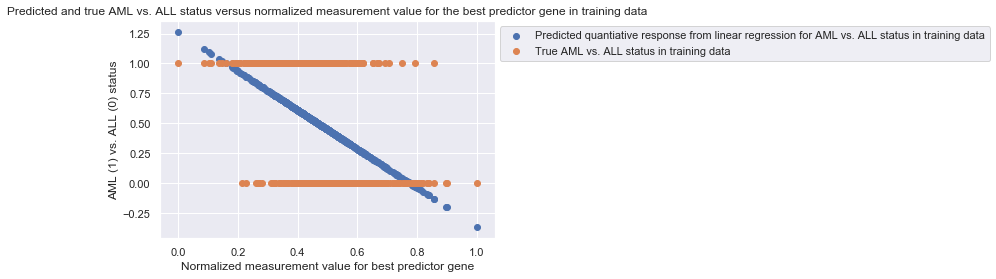

In [30]:
# Plot the predicted continuous response versus the normalized measurement value for the best predictor gene
# Plot the true response (AML vs. ALL) versus the normalized measurement value for the best predictor gene
predicted_y_train = regression.predict(X_train_scaled_reshape);

ax = plt.subplot(111);
plt.scatter(X_train_scaled_reshape, predicted_y_train, label = 'Predicted quantiative response from linear regression for AML vs. ALL status in training data');
plt.scatter(X_train_scaled_reshape, y_train, label = 'True AML vs. ALL status in training data');
plt.xlabel('Normalized measurement value for best predictor gene');
plt.ylabel('AML (1) vs. ALL (0) status');
plt.title('Predicted and true AML vs. ALL status versus normalized measurement value for the best predictor gene in training data');

ax.legend(bbox_to_anchor=(1, 1));

**2.2** **Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.**

In [31]:
# Standard Bayes' classifier is the process of classifying observations with P_hat(Y=1) >= 0.5 to be in the group associated with Y=1 and all observations with P_hat(Y=0) < 0.5 to be in the group associated with Y=0

predicted_y_train_BayesClass = np.round(predicted_y_train)

predicted_y_test = regression.predict(X_test_scaled_reshape)
predicted_y_test_BayesClass = np.round(predicted_y_test)

# Evaluate accuracy on training set
print('Linear regression accuracy on training set:', accuracy_score(y_train, predicted_y_train_BayesClass))

# Evaluate accuracy on testing set
print('Linear regression accuracy on testing set:', accuracy_score(y_test, predicted_y_test_BayesClass))


Linear regression accuracy on training set: 0.7088186356073212
Linear regression accuracy on testing set: 0.6887417218543046



**2.3** **Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? EXCLUDED PER ERRATA -> Are the classifications substantially different?  Explain why this is the case.**

**Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').

In [33]:
# Fit logistic regression model to training set
logreg = LogisticRegression(C=10000, fit_intercept=True, solver='liblinear')
# I am using the default solver = liblinear because it is most appropriate for small samples per the sklearn documentation and therefore it may have the most power
# I am using the default for max_iter = 100 because it is most efficient and the model converges with it
# I am using an intercept because it does not make sense to constrain the intercept to 0 for this model. There can be a baseline risk of AML vs. ALL without any expression of the best predictor gene
logreg.fit(X_train_scaled_reshape, y_train)

# Predictions on training set
logreg_y_hat_train = logreg.predict(X_train_scaled_reshape)
logreg_y_hat_train_proba = logreg.predict_proba(X_train_scaled_reshape)

# Predictions on testing set
logreg_y_hat_test = logreg.predict(X_test_scaled_reshape)
logreg_y_hat_test_proba = logreg.predict_proba(X_test_scaled_reshape)

# Evaluate accuracy on training set
print('Logistic regression accuracy on training set:', accuracy_score(y_train, logreg_y_hat_train))

# Evaluate accuracy on testing set
print('Logistic regression accuracy on testing set:', accuracy_score(y_test, logreg_y_hat_test))


Logistic regression accuracy on training set: 0.7071547420965059
Logistic regression accuracy on testing set: 0.7086092715231788


The training and testing accuracies of the logistic regression model (0.707 and 0.709, respectively) are more similar to each other than are the training and testing accuracies of the linear regression model with the standard Bayes' classifier (0.709 and 0.689, respectively), which indicates that the logistic regression model has less overfitting. The accuracy in the test set for the logistic regression model (0.709) is also slightly larger than the accuracy in the test set for the linear regression model with Bayes' classifier (0.689), which supports that the logistic regression model is more appropriate for these data.

**2.4 Print and interpret the logistic regression coefficients: the 'slope' and the intercept.**

**Create 2 plots (with training and test data) with 4 items displayed on each plot.**
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$.

**Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer.** 


In [34]:
# Show coefficient estimate for the best predictor gene
print('Estimated slope (beta1) from logistic regression:', logreg.coef_[0][0])

# Show intercept estimate
print('Estimated intercept (beta0) from logistic regression:', logreg.intercept_[0])

Estimated slope (beta1) from logistic regression: -8.756350548034725
Estimated intercept (beta0) from logistic regression: 4.0769142201546735


In [35]:
# Translate log odds to odds ratios
print('Estimated odds ratio for slope from logistic regression:', np.exp(logreg.coef_[0][0]))
print('Estimated odds ratio for intercept from logistic regression:', np.exp(logreg.intercept_[0]))

Estimated odds ratio for slope from logistic regression: 0.00015745819743551428
Estimated odds ratio for intercept from logistic regression: 58.96324125433975


The interpretation of the slope coefficient is: For every one unit increase in normalized measurement value for the best predictor gene, there is a predicted 8.76 fold decrease in the log odds of having AML relative to ALL. This is equivalent to saying that for every one unit increase in normalized measurement value for the best predictor gene, the predicted probability of having AML is 0.00016 times as likely as having ALL (odds ratio for having AML vs. ALL = 0.00016).

The interpretation of the intercept is: When the normalized measurement value for the best predictor gene is 0 (i.e., when the gene is not expressed at all), the log odds of having AML relative to ALL is 4.08. This is equivalent to saying that when the normalized measurement value for the best predictor gene is 0 (i.e., when the gene is not expressed at all), the predicted probability of having AML is 58.96 times as likely as having ALL (odds ratio for having AML vs. ALL = 58.96).

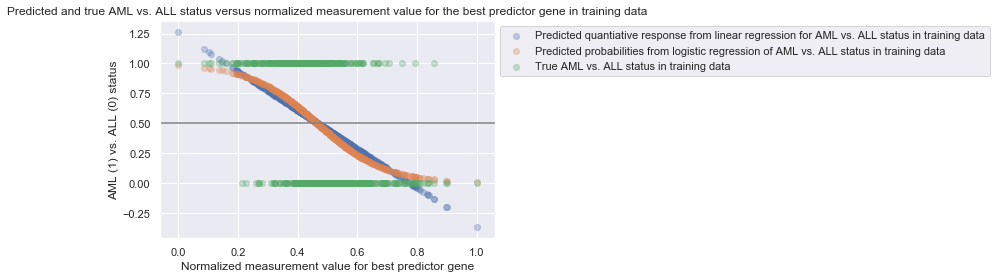

In [36]:
# Plot for training data

ax = plt.subplot(111);
plt.scatter(X_train_scaled_reshape, predicted_y_train, alpha = 0.3, label = 'Predicted quantiative response from linear regression for AML vs. ALL status in training data');
plt.scatter(X_train_scaled_reshape, logreg_y_hat_train_proba[:,1], alpha = 0.3, label = 'Predicted probabilities from logistic regression of AML vs. ALL status in training data');
plt.scatter(X_train_scaled_reshape, y_train, alpha = 0.3, label = 'True AML vs. ALL status in training data');
plt.axhline(0.5, color="gray");
plt.xlabel('Normalized measurement value for best predictor gene');
plt.ylabel('AML (1) vs. ALL (0) status');
plt.title('Predicted and true AML vs. ALL status versus normalized measurement value for the best predictor gene in training data');

ax.legend(bbox_to_anchor=(1, 1));

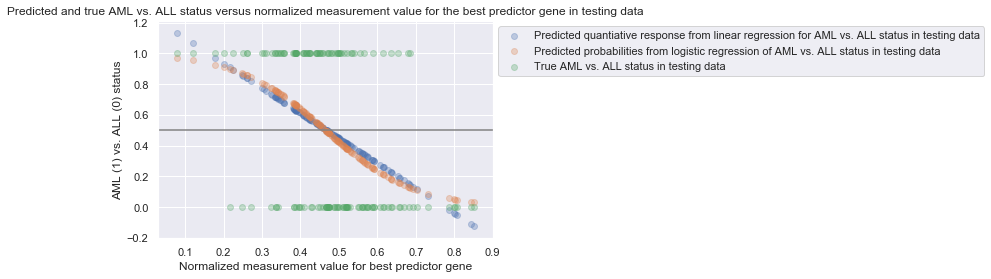

In [37]:
# Plot for testing data

ax = plt.subplot(111);
plt.scatter(X_test_scaled_reshape, predicted_y_test, alpha = 0.3, label = 'Predicted quantiative response from linear regression for AML vs. ALL status in testing data');
plt.scatter(X_test_scaled_reshape, logreg_y_hat_test_proba[:,1], alpha = 0.3, label = 'Predicted probabilities from logistic regression of AML vs. ALL status in testing data');
plt.scatter(X_test_scaled_reshape, y_test, alpha = 0.3, label = 'True AML vs. ALL status in testing data');
plt.axhline(0.5, color="gray");
plt.xlabel('Normalized measurement value for best predictor gene');
plt.ylabel('AML (1) vs. ALL (0) status');
plt.title('Predicted and true AML vs. ALL status versus normalized measurement value for the best predictor gene in testing data');

ax.legend(bbox_to_anchor=(1, 1));

The logistic regression model appears better suited for binary classification than does the linear regression model because the predicted probabilities from logistic regression of AML vs. ALL status in the testing data all fall within 0 to 1 on the y axis of the plot above while linear regression produces some "predicted probabilities" (technically this is the predicted quantitative response from linear regression) than are greater than 1 and less than 0, which are nonsensical values. Furthermore, the logistic regression predictions fall in a sigmoidal curve, which more closely resembles the shape of the true AML vs. ALL status data (green horizontal lines) compared to a diagonal line.

<div class='exercise'> <b> Question 3 [20pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.  


**3.3** Comment on the classification accuracy of training and test set? Given the results above how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole? 

**3.4** Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.

**3.5** Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).

<hr>
### Solutions

**3.1** **Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?**  


In [38]:
# Prepare X data for training and testing for logistic regression in sklearn
# Form arrays where each row holds domain for each predictor
X_train_scaled_multi_reshape = np.array(X_train_scaled).reshape(X_train_scaled.shape[0], X_train_scaled.shape[1])
X_test_scaled_multi_reshape = np.array(X_test_scaled).reshape(X_test_scaled.shape[0], X_test_scaled.shape[1])


In [39]:
# Check sizes
X_train_scaled_multi_reshape.shape, y_train.shape

((601, 7129), (601,))

In [40]:
# Check sizes
X_test_scaled_multi_reshape.shape, y_test.shape

((151, 7129), (151,))

In [41]:
# Fit multiple logistic regression

multi_logreg = LogisticRegression(C=100000, fit_intercept=True, solver='liblinear')
# I am using the default solver = liblinear because it is most appropriate for small samples per the sklearn documentation and therefore it may have the most power
# I am using the default for max_iter = 100 because it is most efficient and the model converges with it
# I am using an intercept because it does not make sense to constrain the intercept to 0 for this model. There can be a baseline risk of AML vs. ALL without any expression of the best predictor gene

multi_logreg.fit(X_train_scaled_multi_reshape, y_train)

# Predictions on training set
multi_logreg_y_hat_train = multi_logreg.predict(X_train_scaled_multi_reshape)

# Predictions on testing set
multi_logreg_y_hat_test = multi_logreg.predict(X_test_scaled_multi_reshape)

# Evaluate accuracy on training set
print('Multiple logistic regression accuracy on training set:', accuracy_score(y_train, multi_logreg_y_hat_train))

# Evaluate accuracy on testing set
print('Multiple logistic regression accuracy on testing set:', accuracy_score(y_test, multi_logreg_y_hat_test))

Multiple logistic regression accuracy on training set: 1.0
Multiple logistic regression accuracy on testing set: 0.7748344370860927


The classification accuracies of the multiple logistic regression model using all genes as predictors using the training and testing data are 1.0 and 0.77, respectively, and are higher than the accuracies obtained from both the linear regression model (training data: 0.709; testing data: 0.689) and logistic regression model (training data: 0.707; testing data: 0.709) using only the best gene as a predictor.

**3.2** **How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.**

**Hint:** **To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.**  


In [43]:
# Based code on CS209A HW 2 solutions as suggested on Ed
y = y_train.values
samples = 100
alpha = 0.05
num_data_points = len(y)
intercepts = []
slopes = []
# Append response variable column to X data in order to facilitate obtaining x and y data from a bootstrapped sample for many iterations 
X_train_scaled_boot = X_train_scaled.copy()
X_train_scaled_boot['Cancer_type'] = y
for i in range(samples):
    df_bootstrapped = X_train_scaled_boot.sample(n=num_data_points, replace=True) # sampling just train data with replacement
    # Prepare shape of true y data from bootstrapped sample for logistic regression in sklearn by transforming to an array
    y_boostrapped = np.array(df_bootstrapped[['Cancer_type']].values).reshape(-1,)
    x_bootstrapped = np.array(df_bootstrapped.loc[:, df_bootstrapped.columns != 'Cancer_type'].values).reshape(df_bootstrapped.loc[:, df_bootstrapped.columns != 'Cancer_type'].shape[0],df_bootstrapped.loc[:, df_bootstrapped.columns != 'Cancer_type'].shape[1])
    multi_logreg_bootstrapped = LogisticRegression(C=100000, fit_intercept=True, solver='liblinear', max_iter=1000)
    # Use liblinear solver because it is best for small samples and so has high power and increase max_iter from the default 100 to 1000 in order to allow model to converge as shown on Ed
    multi_logreg_bootstrapped.fit(x_bootstrapped, y_boostrapped)
    intercepts.append(list(multi_logreg_bootstrapped.intercept_))
    slopes.append(list(multi_logreg_bootstrapped.coef_[0]))

In [47]:
# Show confidence intervals of bootstrapped estimates
data_boot = pd.DataFrame(slopes, columns=X_train_scaled.columns)
df4 = data_boot.quantile([0.025, 0.975])
df5 = df4.transpose()
df5.head()

,0.025,0.975
AFFX-BioB-5_at,0.104048,0.665856
AFFX-BioB-M_at,-0.155023,0.343872
AFFX-BioB-3_at,-0.439878,0.187778
AFFX-BioC-5_at,-0.390366,0.117224
AFFX-BioC-3_at,-0.521034,0.001879


In [48]:
# Find the number of coefficients whose log odds confidence intervals do not span 0
print('Number of coefficients significantly different from 0:', len(df5[(df5[0.975] < 0)]) + len(df5[(df5[0.025] > 0)]))
print('Total number of coefficients in model:', len(df5))

Number of coefficients significantly different from 0: 861
Total number of coefficients in model: 7129


**3.3 Open question: Comment on the classification accuracy of training and test set? Given the results above how would you assest the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole.**

There is high classification accuracy in the training and test sets (1.0 and 0.77, respectively) but the differential between the training and test set accuracy values and the observation that the accuracy in training is 1.0 indicate that there is overfitting in the logistic regression model of AML vs. ALL status with all genes included as predictors. Given the observation that only 861 of 7129 coefficients in the model are significantly different than 0 (have 95% confidence intervals on the log odds scale that do not span 0) supports that the model is including many predictors that do not have a significant effect on the response variable. These excessive predictors may be contributing to overfitting and may exhibit multicolinearity such that the estimates for the predictors are unstable. The trained model with all predictors is therefore not very generalizable. In order to guard against the false sense of security on the accuracy of the model as a whole, I would use cross-validation to assess the accuracy in the training and testing groups more thoroughly. I would also perform correlation tests and plots to reveal any multicolinearity across the predictors if possible. I would also perform regularized logistic regression with the L1 penalty and determine how many predictors' coefficients shrink to 0 after regularization with cross validation to select the best regularization parameter (this would show that there are excess predictors included in the model and would help to guard against readers trusting the accuracy of the model as a whole).

**3.4 Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.**

In [49]:
# Multiple logistic regression with LASSO regularization (L1 norm)

Cs = 10.0**np.arange(-5,5)

logregCV_q4 = LogisticRegressionCV(Cs = Cs,cv=5,solver='liblinear',penalty='l1')
# Use liblinear solver because it is best for small samples and so has high power and leave max_iter at the default of 100 because model converges with it and is more efficient than using higher numbers for max_iter
# Use a range of Cs as shown in the lab and use cv = 5 to perform 5-fold cross validation as modeled in the lab
model_logregCV_q4 = logregCV_q4.fit(X_train_scaled_multi_reshape, y_train)

In [50]:
# Predictions on training set
logregCV_q4_y_hat_train = logregCV_q4.predict(X_train_scaled_multi_reshape)

# Predictions on testing set
logregCV_q4_y_hat_test = logregCV_q4.predict(X_test_scaled_multi_reshape)

# Evaluate accuracy on training set
print('Multiple logistic regression accuracy on training set after regularization:', accuracy_score(y_train, logregCV_q4_y_hat_train))

# Evaluate accuracy on testing set
print('Multiple logistic regression accuracy on testing set after regularization:', accuracy_score(y_test, logregCV_q4_y_hat_test))

Multiple logistic regression accuracy on training set after regularization: 0.9534109816971714
Multiple logistic regression accuracy on testing set after regularization: 0.8410596026490066


**3.5: Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).**

In [51]:
# Make dataframe to hold predictor along with regularized coefficient value
logregCV_q4_coefs = pd.DataFrame(logregCV_q4.coef_.reshape(-1,1), index = X_train_scaled.columns)
logregCV_q4_coefs.columns=['coefficient']

# Show head of predictors with nonzero coefficients after regularization
logregCV_q4_coefs.loc[logregCV_q4_coefs['coefficient'] != 0].head()

,coefficient
AFFX-DapX-3_at,0.467588
AF006609_at,-0.962090
D14695_at,0.628125
D15049_at,0.426785
D26135_at,-0.052600


In [52]:
# Extract the top 10 predictor genes determined previously and inspect their coefficients after regularization
logregCV_q4_coefs.loc[list(X_train_scaled.iloc[:,top_10_index].columns),:]

,coefficient
X76648_at,0.000000
Z11793_at,0.678497
Y08612_at,0.000000
U29175_at,0.000000
X17042_at,0.000000
U50136_rna1_at,0.535885
X61587_at,0.129082
M84526_at,0.000000
X95735_at,0.000000
M31523_at,-1.099597


The coefficients for the effect of each of the top 10 predictor genes on cancer type that are 0 are not supported as important features (X76648_at, Y08612_at, U29175_at, X17042_at, M84526_at, and X95735_at) according to the LASSO regularization approach, but the genes with nonzero estimates for the coefficient (Z11793_at, U50136_rna1_at, X61587_at, and M31523_at) may have important effects. Specifically, the M31523_at gene (the best predictor gene according to t tests) has a -1.10 coefficient estimate, which means that every one unit increase in normalized measurement value for M31523_at is associated with a 1.10 fold decrease in the log odds of having AML versus ALL cancer (in other words, the predicted probability of having AML is 0.33 times less likely (np.exp(-1.099597)) than having ALL for every one unit increase in normalized measurement value of this gene).

<div class='exercise'> <b> Question 4 [25pts]: Multi Class Log Regression </b> </div>

**4.1** Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset? 

**4.2** Split the dataset into train and test, 80-20 split, random_state = 8. 

We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using the training dataset.  It should be easily discernable via labeling/marking in the plot which observations belong to which `cancer_type`.

**4.3** Fit the following two models using crossvalidation: 
- Logistic Regression Multiclass model with linear features. 
- Logistic Regression Multiclass model with Polynomial features, degree = 2.

**4.4** Plot the decision boundaries for each model and interpret the results. Hint: You may utilize the function `overlay_decision_boundary`. 

**4.5** Report and plot the CV scores for the two models and interpret. 


<hr>
### Solutions

**4.1 Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset?**

In [142]:
# Load data from zip file

archive = zipfile.ZipFile('data/hw4_mc_enhance.csv.zip', 'r')
hw4_mc_enhance = pd.read_csv(archive.open('hw4_mc_enhance.csv'),index_col=0)

# Used https://stackoverflow.com/questions/26942476/reading-csv-zipped-files-in-python as a reference

In [55]:
# Examine the dataframe
hw4_mc_enhance.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
0,-1363.276427,-1058.585495,-541.469194,74.349803,-1110.082554,-1545.661845,-2037.029616,-1255.990888,-335.480958,-938.425691,...,1565.618803,-485.680714,-170.261227,-919.114293,1675.050053,389.769289,-526.449219,-268.963924,-779.643092,0.0
1,-796.285053,-1167.103365,7.538493,83.544731,-1116.432539,-1731.392100,249.376523,-1636.960108,-149.080421,-222.783440,...,622.498054,-1275.354673,214.828233,-750.220666,-441.589276,9.841713,-671.911209,-671.911209,-644.272577,0.0
2,-679.139168,-1069.832308,-690.301829,-112.075981,-1199.319178,-1286.387935,-605.465604,-1043.041921,-728.254877,388.011238,...,162.525483,-692.534361,517.498108,-674.674103,1265.396405,-65.192805,-714.859684,3672.066149,-822.021231,0.0
3,-1164.400197,-1109.939891,-990.127218,-238.574994,-1264.607160,-1218.860503,-1255.893511,-1009.732928,-521.768585,-926.953263,...,-31.625831,-621.975549,-458.594630,-630.689198,937.767618,-264.715941,-635.046022,475.944222,-794.070116,0.0
4,-1299.653758,-1401.998536,-1077.543813,-437.344560,-1386.755697,-1726.453259,-1499.988218,-1219.084464,-994.796971,-670.342247,...,383.591216,-905.517483,-36.675640,-1116.739685,316.087213,-210.879518,-953.423549,-291.448812,-1057.945876,0.0


In [232]:
# Examine the dataframe
hw4_mc_enhance.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,-1014.598658,-1048.357272,-823.358695,-315.636838,-1295.949886,-1625.120199,-826.955064,-1175.612555,-588.598064,-534.924646,...,812.768978,-747.263549,16.272227,-801.847334,1031.081628,-3.162310,-723.364564,-40.495922,-810.150889,1.000000
std,297.369331,233.933609,392.662256,215.534283,320.799277,419.687380,562.688520,288.546511,227.362605,489.552685,...,663.320928,176.481127,751.988770,157.068732,966.569338,495.241653,138.805059,882.681724,176.347552,0.817041
min,-2010.202020,-1772.451092,-1619.756151,-930.821077,-1984.530972,-2514.619404,-2766.759937,-1725.591441,-1255.146509,-1552.135008,...,-375.241836,-1484.465401,-853.838447,-1367.829068,-571.900054,-838.747726,-1162.232820,-1266.486530,-1298.638023,0.000000
25%,-1141.429466,-1218.887728,-1076.151552,-454.824979,-1548.108060,-1848.322368,-1203.978707,-1371.756006,-718.014815,-853.188715,...,322.566010,-847.468558,-335.783011,-924.099294,337.355440,-356.629007,-820.617263,-435.750013,-933.182073,0.000000
50%,-1033.862143,-1024.510062,-896.612263,-255.321214,-1257.060242,-1701.504007,-875.340089,-1138.486182,-586.848142,-554.578969,...,639.993676,-750.170322,-130.115409,-783.870080,777.827303,-180.519462,-733.242628,-261.276132,-816.239345,1.000000
75%,-837.607536,-885.604686,-560.246417,-196.687009,-1092.191607,-1259.153655,-508.663556,-978.433566,-416.287415,-173.861061,...,1355.814050,-654.438425,117.823076,-706.793736,1571.382500,209.283781,-609.175359,36.278669,-708.453545,2.000000
max,-385.768608,-477.363374,130.829434,257.521293,-304.800847,-850.745403,929.737460,-466.326738,196.149024,988.039921,...,2482.375600,-230.208352,5082.744968,-428.086002,4221.275650,1363.790953,-427.657222,5845.204223,-268.531949,2.000000


In [143]:
# Determine number of observations in each class (cancer type)
print('Proportion of observations in each class across all data:\n', hw4_mc_enhance.cancer_type.value_counts(normalize=True))
print('\n\nNumber of observations in group 0 (allB):', hw4_mc_enhance.cancer_type.value_counts(normalize=True)[0]*len(hw4_mc_enhance.cancer_type))
print('Number of observations in group 1 (allT):', hw4_mc_enhance.cancer_type.value_counts(normalize=True)[1]*len(hw4_mc_enhance.cancer_type))
print('Number of observations in group 2 (aml):', hw4_mc_enhance.cancer_type.value_counts(normalize=True)[2]*len(hw4_mc_enhance.cancer_type))


Proportion of observations in each class across all data:
 2.0    0.333333
1.0    0.333333
0.0    0.333333
Name: cancer_type, dtype: float64


Number of observations in group 0 (allB): 250.0
Number of observations in group 1 (allT): 250.0
Number of observations in group 2 (aml): 250.0


**4.2 Split the dataset into train and test, 80-20 split, random_state = 8.**

**We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using training dataset.  We should be able to discern from the plot which sample belongs to which `cancer_type`.** 

In [144]:
# Split data into training and testing sets

mc_X_train, mc_X_test, mc_y_train, mc_y_test = train_test_split(hw4_mc_enhance.loc[:, hw4_mc_enhance.columns != 'cancer_type'], 
                                                         hw4_mc_enhance.cancer_type, test_size=0.2, 
                                                         random_state = 8, 
                                                         stratify = hw4_mc_enhance.cancer_type)

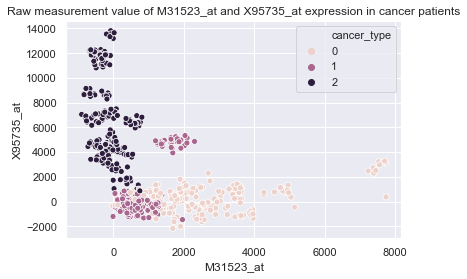

In [145]:
# Create scatter plot of two features using training data

mc_X_train_append_mc_y_train = mc_X_train.copy();
mc_X_train_append_mc_y_train['cancer_type'] = mc_y_train.astype('int64');
sns.scatterplot(x='M31523_at',y='X95735_at', hue='cancer_type', data = mc_X_train_append_mc_y_train).set_title('Raw measurement value of M31523_at and X95735_at expression in cancer patients');


**4.3  Fit the following two models using crossvalidation:**

**Logistic Regression Multiclass model with linear features.**

**Logistic Regression Multiclass model with Polynomial features, degree = 2.**


In [146]:
# Normalize the predictor data by learning the scaling parameters from mc_X_train and transforming mc_X_train and mc_X_test according to these parameters

# Extract relevant features for model and normalize because multiple predictors may influence response variable unfairly if on different absolute scales (different genes may have different basal expressions)

mc_scaler = MinMaxScaler().fit(mc_X_train.loc[:,['M31523_at', 'X95735_at']])

mc_X_train_scaled = pd.DataFrame(mc_scaler.transform(mc_X_train.loc[:,['M31523_at', 'X95735_at']]), columns = mc_X_train.loc[:,['M31523_at', 'X95735_at']].columns)
mc_X_test_scaled = pd.DataFrame(mc_scaler.transform(mc_X_test.loc[:,['M31523_at', 'X95735_at']]), columns=mc_X_test.loc[:,['M31523_at', 'X95735_at']].columns)

In [147]:
# Reshape for sklearn

mc_X_train_scaled_reshape = np.array(mc_X_train_scaled).reshape(mc_X_train_scaled.shape[0], mc_X_train_scaled.shape[1])
mc_X_test_scaled_reshape = np.array(mc_X_test_scaled).reshape(mc_X_test_scaled.shape[0], mc_X_test_scaled.shape[1])

In [148]:
# Check shape
mc_X_train_scaled_reshape.shape, mc_y_train.shape

((600, 2), (600,))

In [149]:
# Check shape
mc_X_test_scaled_reshape.shape, mc_y_test.shape

((150, 2), (150,))

In [150]:
# Logistic regression multiclass model with linear features
Cs = 10.0**np.arange(-5,5)

logregCV = LogisticRegressionCV(Cs = Cs,cv=5,solver='liblinear',penalty='l1',multi_class='ovr')
# Use liblinear solver because it is best for small samples and so has high power and keep max_iter at the default 100 because model converges and low max_iter is more efficient
# Use a range of Cs as shown in the lab and use cv = 5 to perform 5-fold cross validation as modeled in the lab
# Use multiclass ovr regression as needed for question 5.1
model_logregCV = logregCV.fit(mc_X_train_scaled_reshape, mc_y_train)


In [151]:
# Logistic regression multiclass model with polynomial features of degree 2

# Function written in HW3 to add second degree terms to a dataframe
def add_higher_order_polynomial_terms(df, cols_to_add, degree):
    df = df.copy()
    cols = df.loc[:,cols_to_add].columns.copy()
    for col in cols:
        for i in range(2, degree+1):
            df['{}^{}'.format(col, i)] = df[col]**i
    return df

# Use function to add polynomial features without interaction
cols_to_add = mc_X_train_scaled.columns.values
mc_X_train_scaled_poly = add_higher_order_polynomial_terms(mc_X_train_scaled, cols_to_add, 2)
mc_X_test_scaled_poly = add_higher_order_polynomial_terms(mc_X_test_scaled, cols_to_add, 2)

In [78]:
# Inspect data to confirm polynomial features were added
mc_X_train_scaled_poly.head()

,M31523_at,X95735_at,M31523_at^2,X95735_at^2
0,0.250313,0.130529,0.062657,0.017038
1,0.075462,0.594172,0.005694,0.353040
2,0.185473,0.087111,0.034400,0.007588
3,0.267711,0.436474,0.071669,0.190510
4,0.525084,0.202885,0.275713,0.041162


In [79]:
# Inspect data to ensure normalization performed correctly
mc_X_train_scaled_poly.describe()

,M31523_at,X95735_at,M31523_at^2,X95735_at^2
count,600.000000,600.000000,600.000000,600.000000
mean,0.229893,0.289435,0.082744,0.138891
std,0.173040,0.234968,0.143596,0.213054
min,0.000000,0.000000,0.000000,0.000000
25%,0.107431,0.116633,0.011541,0.013603
50%,0.185238,0.179939,0.034313,0.032378
75%,0.303882,0.426996,0.092344,0.182326
max,1.000000,1.000000,1.000000,1.000000


In [152]:
# Prepare train data into arrays for sklearn and check shape
mc_X_train_scaled_poly_reshape = np.array(mc_X_train_scaled_poly).reshape(mc_X_train_scaled_poly.shape[0], mc_X_train_scaled_poly.shape[1])
mc_X_train_scaled_poly_reshape.shape, mc_y_train.shape


((600, 4), (600,))

In [153]:
# Prepare test data into arrays for sklearn and check shape
mc_X_test_scaled_poly_reshape = np.array(mc_X_test_scaled_poly).reshape(mc_X_test_scaled_poly.shape[0], mc_X_test_scaled_poly.shape[1])
mc_X_test_scaled_poly_reshape.shape, mc_y_test.shape


((150, 4), (150,))

In [154]:
# Logistic regression multiclass model with polynomial of degree 2 features
Cs_poly = 10.0**np.arange(-5,5)

logregCV_poly = LogisticRegressionCV(Cs = Cs_poly,cv=5,solver='liblinear',penalty='l1',max_iter=1000, multi_class='ovr')
# Use liblinear solver because it is best for small samples and so has high power and increase max_iter from the default 100 to 1000 to allow model to converge
# Use a range of Cs as shown in the lab and use cv = 5 to perform 5-fold cross validation as modeled in the lab
# Use multiclass ovr regression as needed for question 5.1

model_logregCV_poly = logregCV_poly.fit(mc_X_train_scaled_poly_reshape, mc_y_train)

**4.4 Plot the decision boundary and interpret results. Hint: You may utilize the function `overlay_decision_boundary`** 


In [383]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()] 


    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X) 
    #Plot predictions
    #print(X)
    #print(y.shape)
    ax.scatter(X[0],y)

    #print("Do I predict" , y)
    
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

ValueError: x and y must be the same size

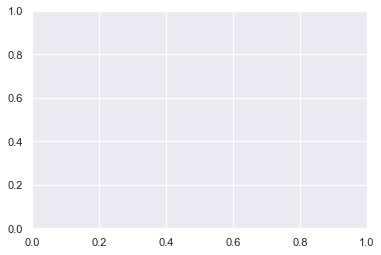

In [384]:
# Use function to generate decision boundary plot

fig1, ax1 = plt.subplots();
overlay_decision_boundary(ax1, model_logregCV, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None);
ax1.set_xlabel('M31523_at normalized measurement value');
ax1.set_ylabel('X95735_at normalized measurement value');
ax1.set_title('Logistic regression multiclass model decision boundary with linear features\n');
#ax1.scatter(mc_X_test_scaled_reshape[0],model_logregCV_y_hat_test)

In [85]:
def overlay_decision_boundary_poly(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    #X = np.c_[xx.flatten(), yy.flatten()] #deleted and added next
    #X = np.c_[xx.flatten(), yy.flatten()].reshape(model.coef_.shape[1])
    
    # Modify mesh to account for 4 predictors in the polynomial model
    X = np.stack((xx.ravel(), yy.ravel(), xx.ravel()**2,yy.ravel()**2),axis=1)


    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X) #deleted this out and added next line
    #y = model(X.reshape(model.coef_.shape[1]))
    #print("Do I predict" , y)
    
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

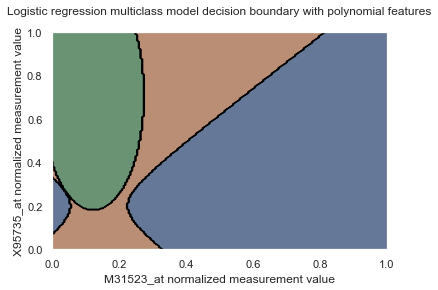

In [86]:
# Use function to generate decision boundary plot

fig2, ax2 = plt.subplots(1)

overlay_decision_boundary_poly(ax2, model_logregCV_poly, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None)
ax2.set_xlabel('M31523_at normalized measurement value');
ax2.set_ylabel('X95735_at normalized measurement value');
ax2.set_title('Logistic regression multiclass model decision boundary with polynomial features\n');
#ax2.scatter

The decision boundary for the linear predictors shows that the 
curved boundary from polynomial features plotted on the axes of the linear predictions

**4.5 Report and plot the CV scores for the two models and interpret.**

In [157]:
cv_scores_logregCV = cross_val_score(logregCV, mc_X_train_scaled_reshape, mc_y_train, cv=5)
print('CV scores for logistic regression multiclass model with linear predictors:', list(cv_scores_logregCV))  

CV scores for logistic regression multiclass model with linear predictors: [0.8, 0.8166666666666667, 0.8583333333333333, 0.8666666666666667, 0.8583333333333333]


In [158]:
cv_scores_logregCV_poly = cross_val_score(logregCV_poly, mc_X_train_scaled_poly_reshape, mc_y_train, cv=5)
print('CV scores for logistic regression multiclass model with polynomial predictors:', list(cv_scores_logregCV_poly))  

CV scores for logistic regression multiclass model with polynomial predictors: [0.9, 0.8666666666666667, 0.8833333333333333, 0.875, 0.85]


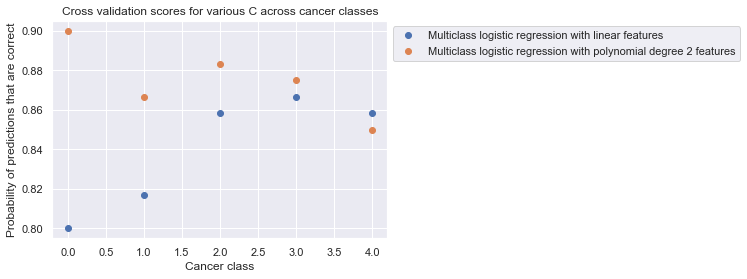

In [89]:
##BAD DELETE THIS
# Plot CV scores
ax = plt.subplot(111);

plt.plot(cv_scores_logregCV, linestyle = " ", marker = 'o', label = "Multiclass logistic regression with linear features");
plt.plot(cv_scores_logregCV_poly, linestyle = " ", marker = 'o', label = "Multiclass logistic regression with polynomial degree 2 features");
plt.title('Cross validation scores for various C across cancer classes');
plt.xlabel('Cancer class');
plt.ylabel('Probability of predictions that are correct');

plt.legend();
ax.legend(bbox_to_anchor=(1, 1));
##cross_val_scores could be giving us the accuracy for the best c already?????

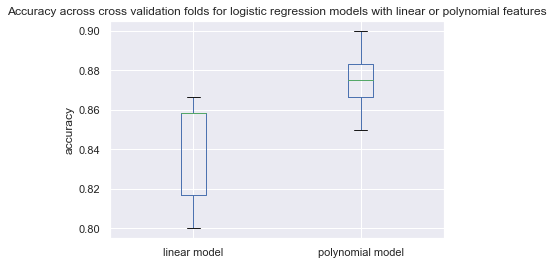

In [159]:
cv_data = {'linear model':cv_scores_logregCV, 'polynomial model': cv_scores_logregCV_poly};
cv_data_df = pd.DataFrame(cv_data);
cv_plot = cv_data_df.plot(kind='box',title='Accuracy across cross validation folds for logistic regression models with linear or polynomial features');
cv_plot.set_ylabel('accuracy');

In [ ]:
sns.boxplot()

<div class='exercise'><b> Question 5: [10 pts] Including an 'abstain' option </b></div>

One of the reasons a hospital might be hesitant to use your cancer classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a specialist, which would incur additional cost.  How could one design a cancer classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**5.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from **Question 4**.  Note that this needs to be evaluated on the patients in the test set. 

**5.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

<hr>
### Solutions

**5.1 More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 4.  Note that this needs to be evaluated on the patients in the test set.**
**
...
**

The average cost per patient in the test set for the OvR logistic regression model without quadratic or interaction terms is XXXXXXXXXXXXX cents.

In [160]:
# Predictions on testing set
model_logregCV_y_hat_test = model_logregCV.predict(mc_X_test_scaled_reshape)

# Evaluate accuracy on testing set
print('OvR multiple logistic regression accuracy on testing set after regularization:', accuracy_score(mc_y_test, model_logregCV_y_hat_test))

# Find misclassification proportion on testing set
print('OvR multiple logistic regression misclassification proportion on testing set after regularization:', 1-accuracy_score(mc_y_test, model_logregCV_y_hat_test))

# Find cost of misclassification across all patients
misclassification_cost = str(round(5000*(1-accuracy_score(mc_y_test, model_logregCV_y_hat_test)),2))
#print('Total OvR multiple logistic regression misclassification cost (in $) on testing set after regularization:', misclassification_cost)
print('Per patient OvR multiple logistic regression misclassification cost (in $) on testing set after regularization:', misclassification_cost)


# Find cost of misclassification per patient
#misclassification_cost_perpatient = str(round(((5000*(1-accuracy_score(mc_y_test, model_logregCV_y_hat_test)))/len(mc_y_test)),2))

#print('Per patient OvR multiple logistic regression misclassification cost (in $) on testing set after regularization:', misclassification_cost_perpatient)


OvR multiple logistic regression accuracy on testing set after regularization: 0.8666666666666667
OvR multiple logistic regression misclassification proportion on testing set after regularization: 0.1333333333333333
Per patient OvR multiple logistic regression misclassification cost (in $) on testing set after regularization: 666.67


In [944]:
model_logregCV.coef_

array([[ 19.44912789,  -7.03615694],
       [ -6.41213069,  -7.13627912],
       [-48.11862885,  21.73694059]])

In [938]:
mc_X_test_scaled_reshape.shape

(150, 2)

In [942]:
sum(model_logregCV_y_hat_test!=mc_y_test)*5000/len(mc_y_test)

666.6666666666666

150

In [914]:
0.133333333333333333333*5000

666.6666666666666

In [909]:
misclassification_cost_perpatient

'4.44'

In [992]:
# Predictions on training set
model_logregCV_y_hat_train = model_logregCV.predict(mc_X_train_scaled_reshape)

# Evaluate accuracy on training set
print('OvR multiple logistic regression accuracy on training set after regularization:', accuracy_score(mc_y_train, model_logregCV_y_hat_train))

# Find misclassification proportion on training set
print('OvR multiple logistic regression misclassification proportion on training set after regularization:', 1-accuracy_score(mc_y_train, model_logregCV_y_hat_train))

# Find cost of misclassification across all patients
misclassification_cost = str(round(5000*(1-accuracy_score(mc_y_train, model_logregCV_y_hat_train)),2))
print('Total OvR multiple logistic regression misclassification cost (in $) on training set after regularization:', misclassification_cost)

# Find cost of misclassification per patient
misclassification_cost_perpatient = str(round(((5000*(1-accuracy_score(mc_y_train, model_logregCV_y_hat_train)))/len(mc_y_train)),2))

print('Per patient OvR multiple logistic regression misclassification cost (in $) on training set after regularization:', misclassification_cost_perpatient)



OvR multiple logistic regression accuracy on training set after regularization: 0.835
OvR multiple logistic regression misclassification proportion on training set after regularization: 0.16500000000000004
Total OvR multiple logistic regression misclassification cost (in $) on training set after regularization: 825.0
Per patient OvR multiple logistic regression misclassification cost (in $) on training set after regularization: 1.38


In [167]:
mc_X_train_scaled

,M31523_at,X95735_at
0,0.250313,0.130529
1,0.075462,0.594172
2,0.185473,0.087111
3,0.267711,0.436474
4,0.525084,0.202885
5,0.313608,0.057787
6,0.070572,0.815697
7,0.114027,0.127542
8,0.503630,0.057848
9,0.157425,0.550865


**5.2 Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.**

In [ ]:
#costperpt = round(5000*(1-accuracy_score(mc_y_test, model_logregCV_y_hat_test)),2)

In [96]:
# Find probabilities that each patient in training set belongs to each cancer category
model_logregCV_y_hat_proba_train = model_logregCV.predict_proba(mc_X_train_scaled_reshape)
model_logregCV_y_hat_proba_train2 = pd.DataFrame(model_logregCV_y_hat_proba_train)
# Per Ed, 'cancer class 0 (aml)', 'cancer class 1 (allT)', 'cancer class 2 (allB)'


# Create column to show probability of being in the classification category with highest probability for each patient
model_logregCV_y_hat_proba_train2['highest_probability'] = model_logregCV_y_hat_proba_train.max(axis=1)
# Create column to show classification category with the highest probability for each patient in the training set
model_logregCV_y_hat_proba_train2['highest_class'] = model_logregCV_y_hat_proba_train2.idxmax(axis=1)


model_logregCV_y_hat_proba_train2.head()

,0,1,2,highest_probability,highest_class
0,0.500810,0.498662,5.278407e-04,0.500810,0
1,0.001072,0.084963,9.139648e-01,0.913965,2
2,0.284335,0.710814,4.851797e-03,0.710814,1
3,0.361848,0.233809,4.043432e-01,0.404343,2
4,0.920521,0.079479,3.981189e-09,0.920521,0


In [97]:
model_logregCV_y_hat_proba_train2

,0,1,2,highest_probability,highest_class
0,0.500810,0.498662,5.278407e-04,0.500810,0
1,0.001072,0.084963,9.139648e-01,0.913965,2
2,0.284335,0.710814,4.851797e-03,0.710814,1
3,0.361848,0.233809,4.043432e-01,0.404343,2
4,0.920521,0.079479,3.981189e-09,0.920521,0
5,0.624348,0.375648,3.639268e-06,0.624348,0
6,0.000220,0.020857,9.789228e-01,0.978923,2
7,0.061819,0.686560,2.516211e-01,0.686560,1
8,0.810867,0.189133,4.180308e-10,0.810867,0
9,0.007200,0.070491,9.223090e-01,0.922309,2


In [98]:
# Training data


# Use different cutoff values for the highest probability of being in the most likely classification category (as calculated above) to be more stringent/lenient in abstaining
# Abstain from classification by logistic regression if the highest probability of being in a classification category is below the cutoff value

cutoff=np.linspace(0,1,100)
cost_per_patient = []
for trial in range(len(cutoff)):
    for i in range(len(model_logregCV_y_hat_proba_train2)):
        #print(i)
        if (model_logregCV_y_hat_proba_train2.loc[i, 'highest_probability'] > cutoff[trial]) == 1:
            model_logregCV_y_hat_proba_train2.loc[i, 'decision'] = model_logregCV_y_hat_proba_train2.loc[i, 'highest_class']
        else:    
            model_logregCV_y_hat_proba_train2.loc[i, 'decision'] = 3 #abstain category
    # Make array of y predictions for cancer types (3 groups here; remove abstain prediction cases)
    model_logregCV_y_hat_proba_train_old_groups = model_logregCV_y_hat_proba_train2[model_logregCV_y_hat_proba_train2.decision != 3]
    trial_y_hat_train_old_groups = np.array(model_logregCV_y_hat_proba_train_old_groups['decision']).reshape(-1,1)

    # Make array of true y values for cancer types (3 groups here; remove abstain prediction cases)
    mc_y_train_array = mc_y_train.copy()
    #mc_y_train_array = mc_y_train_array.reset_index().drop('index',1)
    mc_y_train_old_groups = np.array(mc_y_train_array.loc[model_logregCV_y_hat_proba_train2[model_logregCV_y_hat_proba_train2.decision != 3].index,:]).reshape(-1,1)
    
    # Make array of y predictions for the abstain group to determine how many classified as abstained
    model_logregCV_y_hat_proba_train_new_group = model_logregCV_y_hat_proba_train2[model_logregCV_y_hat_proba_train2.decision == 3]
    trial_y_hat_train_new_group = np.array(model_logregCV_y_hat_proba_train_new_group['decision']).reshape(-1,1)
    num_abstain = len(trial_y_hat_train_new_group)
    # Find overall cost due to abstaining
    cost_abstain = 1000*num_abstain
    # Find overall cost due to misclassification of cancer type
    cost_misclassify = 5000*(1-accuracy_score(mc_y_train_old_groups, trial_y_hat_train_old_groups))
    # Find overall cost per patient
    #cost_per_patient.append((cost_abstain + cost_misclassify)/(num_abstain+len(mc_y_train_old_groups)))
    cost_per_patient.append(cost_abstain + cost_misclassify)
    
rounded_cost_per_patient = np.around(cost_per_patient, decimals=2)

ax = plt.subplot(111)

plt.plot(cutoff,cost_per_patient)
plt.title('Cost per patient for different cutoff values for abstaining from classification in the training set')
plt.xlabel('Cutoff value')
plt.ylabel('Cost per patient')

print('Lowest cost per patient:', np.min(rounded_cost_per_patient), '\n')
print('Cutoff to use for abstaining to achieve lowest cost per patient:', cutoff[np.argmin(cost_per_patient)])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [164]:
model_logregCV_y_hat_proba_train2

,0,1,2,highest_probability,highest_class,decision
0,0.500810,0.498662,5.278407e-04,0.500810,0,3.0
1,0.001072,0.084963,9.139648e-01,0.913965,2,2.0
2,0.284335,0.710814,4.851797e-03,0.710814,1,3.0
3,0.361848,0.233809,4.043432e-01,0.404343,2,3.0
4,0.920521,0.079479,3.981189e-09,0.920521,0,0.0
5,0.624348,0.375648,3.639268e-06,0.624348,0,3.0
6,0.000220,0.020857,9.789228e-01,0.978923,2,2.0
7,0.061819,0.686560,2.516211e-01,0.686560,1,3.0
8,0.810867,0.189133,4.180308e-10,0.810867,0,0.0
9,0.007200,0.070491,9.223090e-01,0.922309,2,2.0


In [348]:
cutoff=np.linspace(0,0.99,10)
cost_per_patient = []
for trial in range(len(cutoff)):
    for i in range(len(model_logregCV_y_hat_proba_train2)):
    #print(i)
        if (model_logregCV_y_hat_proba_train2.loc[i, 'highest_probability'] > cutoff[trial])== 1:
            model_logregCV_y_hat_proba_train2.loc[i, 'decision'] = model_logregCV_y_hat_proba_train2.loc[i, 'highest_class']
        else:    
            model_logregCV_y_hat_proba_train2.loc[i, 'decision'] = 3 #abstain category
    # Make array of y predictions for cancer types (3 groups here; remove abstain prediction cases)
    model_logregCV_y_hat_proba_train_old_groups2 = model_logregCV_y_hat_proba_train2[model_logregCV_y_hat_proba_train2.decision != 3]
    #trial_y_hat_train_old_groups = np.array(model_logregCV_y_hat_proba_train_old_groups['decision']).reshape(-1,1)
    model_logregCV_y_hat_proba_train_new_groups2 = model_logregCV_y_hat_proba_train2[model_logregCV_y_hat_proba_train2.decision == 3]
    cost_abstain2 = 1000*len(model_logregCV_y_hat_proba_train_new_groups2)
    mc_y_train_oldgrps = mc_y_train.copy()
    mc_y_train_oldgrps_newindex = mc_y_train_oldgrps.reset_index()
    mc_y_train_oldgrps_newindex_drop = mc_y_train_oldgrps_newindex.drop('index',1)
    mc_y_train_oldgrps_newindex_drop_selectold = mc_y_train_oldgrps_newindex_drop.iloc[model_logregCV_y_hat_proba_train_old_groups2.index,:]
    #true values for old grps
    mc_y_train_oldgrps_newindex_drop_selectold_reshape = np.array(mc_y_train_oldgrps_newindex_drop_selectold).reshape(-1,1)
    y_pred_oldgrps = np.array(model_logregCV_y_hat_proba_train_old_groups2.decision).reshape(-1,1) #y hat old grps
    cost_misclassify_2 = 5000*(1-accuracy_score(mc_y_train_oldgrps_newindex_drop_selectold_reshape, y_pred_oldgrps))*len(y_pred_oldgrps)
    total_cost08 = cost_misclassify_2 + cost_abstain2
    perpatient_cost08 = total_cost08/(len(model_logregCV_y_hat_proba_train2))
    cost_per_patient.append(perpatient_cost08)
    

Text(0, 0.5, 'Cost per patient in $')

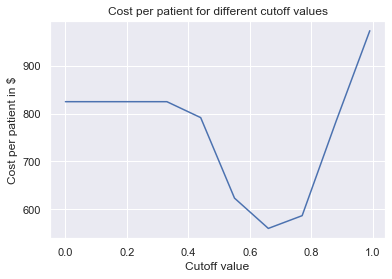

In [391]:
plt.plot(cutoff,cost_per_patient);
plt.title('Cost per patient for different cutoff values')
plt.xlabel('Cutoff value')
plt.ylabel('Cost per patient in $')

In [392]:
min_cost = np.min(cost_per_patient)
print('minimum cost:', min_cost)
min_cutoff = cutoff[np.argmin(cost_per_patient)]
print('minimum cutoff:', min_cutoff)


minimum cost: 560.0
minimum cutoff: 0.66


In [331]:

for i in range(len(model_logregCV_y_hat_proba_train2)):
    #print(i)
    if (model_logregCV_y_hat_proba_train2.loc[i, 'highest_probability'] > 0.665)== 1:
        model_logregCV_y_hat_proba_train2.loc[i, 'decision'] = model_logregCV_y_hat_proba_train2.loc[i, 'highest_class']
    else:    
        model_logregCV_y_hat_proba_train2.loc[i, 'decision'] = 3 #abstain category
    # Make array of y predictions for cancer types (3 groups here; remove abstain prediction cases)
    model_logregCV_y_hat_proba_train_old_groups2 = model_logregCV_y_hat_proba_train2[model_logregCV_y_hat_proba_train2.decision != 3]
    #trial_y_hat_train_old_groups = np.array(model_logregCV_y_hat_proba_train_old_groups['decision']).reshape(-1,1)
    model_logregCV_y_hat_proba_train_new_groups2 = model_logregCV_y_hat_proba_train2[model_logregCV_y_hat_proba_train2.decision == 3]
    cost_abstain2 = 1000*len(model_logregCV_y_hat_proba_train_new_groups2)
    mc_y_train_oldgrps = mc_y_train.copy()
    mc_y_train_oldgrps_newindex = mc_y_train_oldgrps.reset_index()
    mc_y_train_oldgrps_newindex_drop = mc_y_train_oldgrps_newindex.drop('index',1)
    mc_y_train_oldgrps_newindex_drop_selectold = mc_y_train_oldgrps_newindex_drop.iloc[model_logregCV_y_hat_proba_train_old_groups2.index,:]
    #true values for old grps
    mc_y_train_oldgrps_newindex_drop_selectold_reshape = np.array(mc_y_train_oldgrps_newindex_drop_selectold).reshape(-1,1)
    y_pred_oldgrps = np.array(model_logregCV_y_hat_proba_train_old_groups2.decision).reshape(-1,1) #y hat old grps
    cost_misclassify_2 = 5000*(1-accuracy_score(mc_y_train_oldgrps_newindex_drop_selectold_reshape, y_pred_oldgrps))*len(y_pred_oldgrps)
    total_cost08 = cost_misclassify_2 + cost_abstain2
    perpatient_cost08 = total_cost08/(len(model_logregCV_y_hat_proba_train2))
    

In [332]:
# Make array of y predictions for cancer types (3 groups here; remove abstain prediction cases)
model_logregCV_y_hat_proba_train_old_groups2 = model_logregCV_y_hat_proba_train2[model_logregCV_y_hat_proba_train2.decision != 3]
#trial_y_hat_train_old_groups = np.array(model_logregCV_y_hat_proba_train_old_groups['decision']).reshape(-1,1)
model_logregCV_y_hat_proba_train_new_groups2 = model_logregCV_y_hat_proba_train2[model_logregCV_y_hat_proba_train2.decision == 3]
cost_abstain2 = 1000*len(model_logregCV_y_hat_proba_train_new_groups2)
#misclass2 = 


In [333]:
mc_y_train_oldgrps = mc_y_train.copy()

In [334]:
mc_y_train_oldgrps_newindex = mc_y_train_oldgrps.reset_index()

In [335]:
mc_y_train_oldgrps_newindex_drop = mc_y_train_oldgrps_newindex.drop('index',1)

In [336]:
mc_y_train_oldgrps_newindex_drop_selectold = mc_y_train_oldgrps_newindex_drop.iloc[model_logregCV_y_hat_proba_train_old_groups2.index,:]

In [337]:
#true values for old grps
mc_y_train_oldgrps_newindex_drop_selectold_reshape = np.array(mc_y_train_oldgrps_newindex_drop_selectold).reshape(-1,1)

In [338]:
y_pred_oldgrps = np.array(model_logregCV_y_hat_proba_train_old_groups2.decision).reshape(-1,1) #y hat old grps

In [339]:
cost_misclassify_2 = 5000*(1-accuracy_score(mc_y_train_oldgrps_newindex_drop_selectold_reshape, y_pred_oldgrps))*len(y_pred_oldgrps)

In [340]:
cost_misclassify_2

194999.9999999999

In [341]:
cost_abstain2

133000

In [342]:
total_cost08 = cost_misclassify_2 + cost_abstain2

In [343]:
perpatient_cost08 = total_cost08/(len(model_logregCV_y_hat_proba_train2))

In [344]:
perpatient_cost08

546.6666666666665

In [927]:
# Find probabilities that each patient in testing set belongs to each cancer category
model_logregCV_y_hat_proba_test = model_logregCV.predict_proba(mc_X_test_scaled_reshape)
model_logregCV_y_hat_proba_test = pd.DataFrame(model_logregCV_y_hat_proba_test)
# Per Ed, 'cancer class 0 (aml)', 'cancer class 1 (allT)', 'cancer class 2 (allB)'

# Create column to show classification category with the highest probability for each patient in the test set
model_logregCV_y_hat_proba_test['highest_class'] = model_logregCV_y_hat_proba_test.idxmax(axis=1)

# Create column to show probability of being in the classification category with highest probability for each patient
model_logregCV_y_hat_proba_test['highest_probability'] = model_logregCV_y_hat_proba_test.max(axis=1)

model_logregCV_y_hat_proba_test.head()

,0,1,2,highest_class,highest_probability
0,0.000306,0.011572,0.988122,2,2.000000
1,0.000752,0.152084,0.847164,2,2.000000
2,0.000178,0.015250,0.984572,2,2.000000
3,0.930407,0.067833,0.001761,0,0.930407
4,0.415222,0.583287,0.001490,1,1.000000


Lowest cost per patient: 666.67 

Cutoff to use for abstaining to achieve lowest cost per patient: 0.0


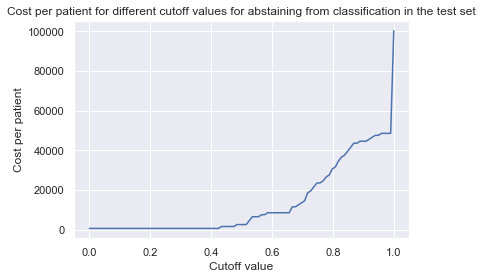

In [929]:
# Testing data

# Use different cutoff values for the highest probability of being in the most likely classification category (as calculated above) to be more stringent/lenient in abstaining
# Abstain from classification by logistic regression if the highest probability of being in a classification category is below the cutoff value

cutoff=np.linspace(0,1,100)
cost_per_patient = []
for trial in range(len(cutoff)):
    for i in range(len(model_logregCV_y_hat_proba_test)):
        #print(i)
        if (model_logregCV_y_hat_proba_test.loc[i, 'highest_probability'] > cutoff[trial]) == 1:
            model_logregCV_y_hat_proba_test.loc[i, 'decision'] = model_logregCV_y_hat_proba_test.loc[i, 'highest_class']
        else:    
            model_logregCV_y_hat_proba_test.loc[i, 'decision'] = 3 #abstain category
    # Make array of y predictions for cancer types (3 groups here; remove abstain prediction cases)
    model_logregCV_y_hat_proba_test_old_groups = model_logregCV_y_hat_proba_test[model_logregCV_y_hat_proba_test.decision != 3]
    trial_y_hat_test_old_groups = np.array(model_logregCV_y_hat_proba_test_old_groups['decision']).reshape(-1,1)

    # Make array of true y values for cancer types (3 groups here; remove abstain prediction cases)
    mc_y_test_array = mc_y_test
    mc_y_test_array = mc_y_test_array.reset_index().drop('index',1)
    mc_y_test_old_groups = np.array(mc_y_test_array.loc[model_logregCV_y_hat_proba_test[model_logregCV_y_hat_proba_test.decision != 3].index,:]).reshape(-1,1)
    
    # Make array of y predictions for the abstain group to determine how many classified as abstained
    model_logregCV_y_hat_proba_test_new_group = model_logregCV_y_hat_proba_test[model_logregCV_y_hat_proba_test.decision == 3]
    trial_y_hat_test_new_group = np.array(model_logregCV_y_hat_proba_test_new_group['decision']).reshape(-1,1)
    num_abstain = len(trial_y_hat_test_new_group)
    # Find overall cost due to abstaining
    cost_abstain = 1000*num_abstain
    # Find overall cost due to misclassification of cancer type
    cost_misclassify = 5000*(1-accuracy_score(mc_y_test_old_groups, trial_y_hat_test_old_groups))
    # Find overall cost per patient
    cost_per_patient.append((cost_abstain + cost_misclassify)/(num_abstain+len(mc_y_test_old_groups)))
    #cost_per_patient.append(cost_abstain + cost_misclassify)
rounded_cost_per_patient = np.around(cost_per_patient, decimals=2)

ax = plt.subplot(111)

plt.plot(cutoff,cost_per_patient)
plt.title('Cost per patient for different cutoff values for abstaining from classification in the test set')
plt.xlabel('Cutoff value')
plt.ylabel('Cost per patient')

print('Lowest cost per patient:', np.min(rounded_cost_per_patient), '\n')
print('Cutoff to use for abstaining to achieve lowest cost per patient:', cutoff[np.argmin(cost_per_patient)])

In [ ]:
# 5.2 distance from decision boundary
# https://stackoverflow.com/questions/32074239/sklearn-getting-distance-of-each-point-from-decision-boundary

y52 = model_logregCV.decision_function(mc_X_test_scaled_reshape)
w_norm52 = np.linalg.norm(model_logregCV.coef_)
dist52 = y52 / w_norm52

# Find probabilities that each patient in testing set belongs to each cancer category
model_logregCV_y_hat_proba_test = dist52
model_logregCV_y_hat_proba_test = pd.DataFrame(model_logregCV_y_hat_proba_test)
# Per Ed, 'cancer class 0 (aml)', 'cancer class 1 (allT)', 'cancer class 2 (allB)'

# Create column to show classification category with the highest probability for each patient in the test set
model_logregCV_y_hat_proba_test['highest_class'] = model_logregCV_y_hat_proba_test.idxmin(axis=1)

# Create column to show probability of being in the classification category with highest probability for each patient
model_logregCV_y_hat_proba_test['highest_probability'] = model_logregCV_y_hat_proba_test.min(axis=1)

#model_logregCV_y_hat_proba_test.head()

# Testing data

# Use different cutoff values for the highest probability of being in the most likely classification category (as calculated above) to be more stringent/lenient in abstaining
# Abstain from classification by logistic regression if the highest probability of being in a classification category is below the cutoff value

cutoff=np.linspace(-0.5,0.5,100)
cost_per_patient = []
for trial in range(len(cutoff)):
    for i in range(len(model_logregCV_y_hat_proba_test)):
        #print(i)
        if (model_logregCV_y_hat_proba_test.loc[i, 'highest_probability'] < cutoff[trial]) == 1:
            model_logregCV_y_hat_proba_test.loc[i, 'decision'] = model_logregCV_y_hat_proba_test.loc[i, 'highest_class']
        else:    
            model_logregCV_y_hat_proba_test.loc[i, 'decision'] = 3 #abstain category
    # Make array of y predictions for cancer types (3 groups here; remove abstain prediction cases)
    model_logregCV_y_hat_proba_test_old_groups = model_logregCV_y_hat_proba_test[model_logregCV_y_hat_proba_test.decision != 3]
    trial_y_hat_test_old_groups = np.array(model_logregCV_y_hat_proba_test_old_groups['decision']).reshape(-1,1)

    # Make array of true y values for cancer types (3 groups here; remove abstain prediction cases)
    mc_y_test_array = mc_y_test
    mc_y_test_array = mc_y_test_array.reset_index().drop('index',1)
    mc_y_test_old_groups = np.array(mc_y_test_array.loc[model_logregCV_y_hat_proba_test[model_logregCV_y_hat_proba_test.decision != 3].index,:]).reshape(-1,1)
    
    # Make array of y predictions for the abstain group to determine how many classified as abstained
    model_logregCV_y_hat_proba_test_new_group = model_logregCV_y_hat_proba_test[model_logregCV_y_hat_proba_test.decision == 3]
    trial_y_hat_test_new_group = np.array(model_logregCV_y_hat_proba_test_new_group['decision']).reshape(-1,1)
    num_abstain = len(trial_y_hat_test_new_group)
    # Find overall cost due to abstaining
    cost_abstain = 1000*num_abstain
    # Find overall cost due to misclassification of cancer type
    cost_misclassify = 5000*(1-accuracy_score(mc_y_test_old_groups, trial_y_hat_test_old_groups))
    # Find overall cost per patient
    cost_per_patient.append((cost_abstain + cost_misclassify)/(num_abstain+len(mc_y_test_old_groups)))

rounded_cost_per_patient = np.around(cost_per_patient, decimals=2)

ax = plt.subplot(111)

plt.plot(cutoff,cost_per_patient)
plt.title('Cost per patient for different cutoff values for abstaining from classification in the test set')
plt.xlabel('Cutoff value')
plt.ylabel('Cost per patient')

print('Lowest cost per patient:', np.min(rounded_cost_per_patient), '\n')
print('Cutoff to use for abstaining to achieve lowest cost per patient:', cutoff[np.argmin(cost_per_patient)])